# Optimizing Risks for a Portfolio of Cryptocurrencies
> "Intro into Optimizing Risks for a portfolio of cryptocurrencies using stochastic discount factor"

- author: <a href='https://www.linkedin.com/in/vladimir-eremin-d/'>Vladimir Eremin</a>, <a href='https://yourdatablog.com/about/'>Dmytro Karabash</a>, <a href=http://maximk.com//>Maxim Korotkov</a> 
- categories: [sdf, treasury, crypto]
- image: images/pixabay-game-of-thrones-4180794_640.jpg
- permalink: /cryptosdf/

In [ ]:
#install requirements if needed
!pip install cvxpy==1.0.31 pandas_datareader pandas matplotlib seaborn -q

In [ ]:
#import modules
import cvxpy as cp
import pandas_datareader as pdr
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import math
import os.path
import time

#select plotting style
import matplotlib
import seaborn as sb
matplotlib.style.use('fivethirtyeight')

#seaborn-white  fivethirtyeight
import sys
#Python versiond
print(sys.version)

print(cp.__version__)

In [ ]:
#read input dataset that was downladed from the binance 
fuldf = pd.read_pickle('data.pickle')
y_label = fuldf.columns[0]
factors = (fuldf.columns[1:]
            .tolist()
          )


total_size = fuldf.shape[0]
# print('Combined DF size:', total_size,'\nFull range: ', fuldf.iloc[0].name,fuldf.iloc[-1].name)
train_set = .8

train_id = int( total_size * train_set)
df_train = fuldf.iloc[:train_id]
df_test = fuldf.iloc[train_id:]
split_index = fuldf.iloc[train_id].name
# print('Training period: ', df_train.iloc[0].name,'-',df_train.iloc[-1].name,'shape:',df_train.shape[0],'\nTesing period:',df_test.iloc[0].name,df_test.iloc[-1].name,'shape:',df_test.shape[0],)


## Data Acquisition

---

The data for this exercise was obtained from the Binance API using the Python API client `python-binance`.

An example of the data acquisition code:
>Note: Install the module if needed using pip:
>#pip install python-binance

```python
from binance.client import Client
binance_api_key = 'YOUR-API-KEY'
binance_api_secret = 'YOUR-API-SECRET'
binance_client = Client(api_key=binance_api_key
				,api_secret=binance_api_secret)
klines = binance_client.get_historical_klines(symbol
				 ,kline_size, date_from, date_to)
data = pd.DataFrame(klines, columns = [COLUMNS])
```

Following daily pairs was downloaded and formatted to pd DataFrame:
1.  BTCUSDT
2.  ETHUSDT
3.  BNBUSDT
4.  LTCUSDT

For each timepoint, Binance provides conventional OHLC (Open, High, Low, Close) and Volume data. In this exercise, we used only the `Close` column. It's possible, though to consider the combination of all five values and came up with a more reliable metric, for example: the weighted average price.

The joint time-series of four crypto assets looks the following:

In [ ]:
df_train.head()

Each trading pair has a different amount of data available: The oldest tradable crypto instruments on Binance are BTCUSDT and ETHUSDT - data points are available from _2017-08-17_. For BNBUSDT and LTCUSDT first trading days are _2017-11-06_ and _2017-12-13_, respectively.

We joined these time series together on the earliest common trading date: _2017-12-13_ up to _2021-06-14_. The full joint dataset size is equal to 1280 samples.

In order to properly infer the SDF, We split the dataset into training and testing sets at _2020-10-02_.

Training interval: _2017-12-13_ to _2020-10-02_ (1024 data points).

&nbsp;

Below is the joint plot of the full dataset in the logarithmic scale. The dotted line represents the train-test split at _2020-10-02_

In [ ]:
plot_data =np.log(fuldf)
fig , ax = plt.subplots(figsize=(12,7))
# ax1 = ax.twinx()
# plot_data.drop(y_label,axis=1).plot(ax=ax)
plot_data.plot(ax=ax,alpha=0.8)
ax.legend(loc=0)
ax.set(title='Assets',xlabel='Date',ylabel='price, log scale');

ax.axvline(split_index,color='grey', linestyle='--', lw=2);

In [ ]:
#Transform raw data to log-return format:
lret_data = np.log1p(df_train.pct_change()).dropna(axis=0,how='any')

## II. Data Transformation
---
In order to be properly trained, input time series has to be transfored into the log-return format:

$r_t = \ln{\frac{P_t}{P_{t-1}}}$

Where $P_t$ is a price of the asset at time $t$.

The SDF model needs two vectors to perform the optimization: 

1. Feature vector $I$
2. Target vector $R$

The $R$ vector contains values shifted to $t+1$ compared to the $I$ vector:

$R = \begin{pmatrix}
r_{1}
\\ \vdots
\\r_{t}
\end{pmatrix}
I = \begin{pmatrix}
r_{0,0} & \dots & r_{0,l} \\ 
\vdots   & & \vdots \\ 
r_{t-1,0} & \dots & r_{t-1,l} 
\end{pmatrix}
$

Where $l$ is the number of features in the model.



In [ ]:
R = lret_data[y_label].shift(1).iloc[1:].values.reshape((-1,1))
I = lret_data[factors].iloc[1:].values
# assert R.shape[0] == I.shape[0] and I.shape[1]==3

print('R:',R.shape,'\n',R[:10]
,'\n I:',I.shape,'\n',I[:10,:])

In [ ]:
#correlation matrix
F= pd.concat([pd.DataFrame(R),pd.DataFrame(I)],axis=1)
F.columns =   [y_label]+factors
F.cov()

In [ ]:
f = plt.figure(figsize=(10, 10))
cov_data = F.cov()
mask = np.triu(np.ones_like(cov_data))
dataplot = sb.heatmap(cov_data.corr(), cmap="YlGnBu", annot=True, mask=mask)
plt.title('Covariance Matrix', fontsize=16);

## Model 

---

Our goal is to explain the differences in the cross-section of returns $R$ for individual stocks.

Let $R_{t+1}$; denote the return of BTCUSDT at time $t + 1$. The fundamental no-arbitrage assumption is
equivalent to the existence of a stochastic discount factor (SDF) $M_{t+1}$ such that for any return in excess of the risk-free rate 

$R^e_{t+1} = R_{t+1}- R^f_{t+1}$ it holds:

$E_t[M_{t+1} R^e_{t+1}]= 0$


For demonstration purpose and in seak of simplicity, we assume that
$R^e_{t} = R_{t}$: excesses return of the BTCUSDT is the same as 
the market return.

We consider the SDF formulation as:

$M_{t+1} = 1 - \sum_{i=1}^N w_{t,i} R_{t+1} = 1 -w_t^T R_{t+1}$


The Generalized Method of Moments (GMM) was used to approximate the SDF $M$ vector. 
The first moment condition equation can be expressed as following:

$ \underset{M}{\text{min}}\underset{t}{\sum} || M(I_{t}) R^e_{t+1}||^2 $

Since the above problem is convex, we can estimate the SDF for BTC using the `cvxpy` framework.

In [ ]:
#4 - Solve GMM problem
n = R.shape[0]
#define weights for the SDF
w = cp.Variable(shape=(I.shape[1]
                        ,1),nonneg=True)

#define SDF 
M = I @ w

#Define expression
Sigma = M @ R.T

#Construct the problem
prob = cp.Problem(cp.Minimize( cp.norm(Sigma)  )
                  # , [cp.geo_mean(M) >= 1 , ]
                 , [cp.sum(w) == 1 
                    ,cp.sum(M) == 1 ]
                  
                )

prob.solve(verbose=True
           #, max_iters = 300
           )

print('SDF weights from BTC:\n',dict(zip(factors,w.value)))

In [13]:
def sharpe(x):
  return (x.mean() / x.std() * np.sqrt(365))



def plot_return(data,title):
  datac = data.copy()
  fig , ax = plt.subplots(figsize=(13,5))

  y_return = (datac[y_label].pct_change().fillna(0)+1)
  
  p_return = ((datac[factors].pct_change().fillna(0) + 1)
              .apply(lambda x: (x @ w.value)[0] ,axis =1)
              .rename('SDF Portfolio')
              )
  
  
  
  p_return_c = p_return.cumprod()
  y_return_c = y_return.cumprod()
  portfolio_benchmark = pd.concat([y_return_c,p_return_c],axis=1)

  portfolio_benchmark.plot(ax=ax)
  ax.legend(loc=0)
  ax.set(title=title,ylabel='growth factor',xlabel='date')
  
  return portfolio_benchmark

def calc_metrics(data):
  #y_return = data[y_label].pct_change().fillna(0)
  
  p_return = ((data[factors].pct_change().fillna(0))
              .apply(lambda x: (x @ w.value)[0] ,axis =1)
              .rename('SDF Portfolio')
              )
  y_return = data.pct_change().fillna(0)
  y_return['SDF Portfolio'] = p_return
    
  #portfolio_ret = pd.concat([y_return,p_return],axis=1)
      
  return '\nSharpe ration: '+str(portfolio_ret.apply(sharpe).round(3).to_dict()) 
    

## Results
Below is the result of computing the SDF portfolio on the training dataset and plotting it against the index portfolio (BTCUSDT):

Portfolio growth (x times):
{'BTCUSDT': -0.34, 'SDF Portfolio': 2.92}
Sharpe ration: {'BTCUSDT': 0.222, 'SDF Portfolio': 0.997}


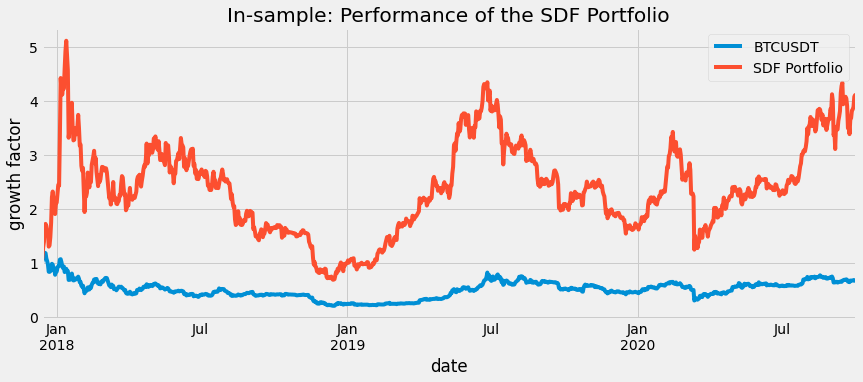

In [14]:
portfolio_benchmark = plot_return(df_train,'In-sample: Performance of the SDF Portfolio')


print('Portfolio growth (x times):\n'+\
          str((portfolio_benchmark.iloc[-1] - 1).round(2).to_dict())+\
    calc_metrics(df_train)) 

Resulted plot and metrics for the hold-out dataset:

In [15]:
portfolio_benchmark_ho = plot_return(df_test,'Out-of-sample: Performance of the SDF Portfolio')


print('Portfolio growth factor:\n'+\
          str((portfolio_benchmark_ho.iloc[-1] - 1).round(2).to_dict())+\
    calc_metrics(df_test)) 

Portfolio growth factor:
{'BTCUSDT': 2.84, 'SDF Portfolio': 11.08}
Sharpe ration: {'BTCUSDT': 2.704, 'SDF Portfolio': 3.394}


## Conclusion
---
In this exercise, we estimated the SDF model for BTCUSDT using a GMM method and calculated the sample portfolio performance on the in-sample and hold-out time intervals.

The results of the model can be interpreted as follow:

Through the entire year of 2018, the BTCUSDT showed poor performance (-34%), resulting in the next-to-zero Sharpe ratio. On the same interval model portfolio showed a 300% growth but not without high volatility (Sharpe is still less than 1).

On the hold-out dataset both index and the model portfolio showed significant growth by 284% and 1108%, respectively. The Sharpe ratio for both index and the model portfolio is higher than 2: 2.7 and 3.4, respectively.

Given the results from the model run, we can confidently conclude that our SDF model portfolio achieved better performance than the index with preserving the higher Sharpe ratio.